In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [94]:
# Load data
model_type = "ols"
data_len = 660 # 440, 660, 760, 1560
is_sent = True
predicted = "sp_close_lead1"

df_w = load_data(file_name=f"df_weekly_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_weekly_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [95]:
data_dict["model_features"].update(predicted=predicted)
data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{data_dict['model_features']['predicted']}_sent{is_sent}")

# correlation

In [96]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    'vixo',
     'naaim_ind',
     'naaim_max',
     'naaim_q1',
     'ff_M_RF',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     'termspread',
     'pc_ratio',
     # 'fears35',
     'aaii_Bullish',
     'aaii_Bearish',
     'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     # 'sp_close_lag3',
     # 'sp_close_lag4',
     # 'sp_close_lag5',
     # 'sp_close_lag6',
     # 'sp_close_lag7',
]

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

In [97]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [98]:
df_cross_corr(df_ws,
              [item for item in cols if item not in data_dict["data"]["sp_cols"]] ,#+ ["sp_close"],
              data_dict["model_features"]["predicted"],
              show_plot=False,
             figsize=(5, 3))

[['vixo', 0, 0.466],
 ['naaim_ind', 0, 0.25],
 ['naaim_max', 1, 0.089],
 ['naaim_q1', 0, 0.116],
 ['ff_M_RF', 0, 0.469],
 ['ff_SMB', 0, 0.166],
 ['ff_HML', 0, 0.17],
 ['ff_RMW', 0, 0.185],
 ['ff_CMA', 10, 0.093],
 ['termspread', 5, 0.084],
 ['pc_ratio', 0, 0.444],
 ['aaii_Bullish', 0, 0.154],
 ['aaii_Bearish', 0, 0.175],
 ['aaii_Neutral', 0, 0.152]]

In [99]:
# df_ws, _ = shift_var_relative_to_df(df_ws,
#                                  shift_var=["aaii_Bullish"],
#                                  no_lags=[7])
# data_dict["data_transformation"].update(shift_var=_)
# df_ws = df_ws.dropna()

# Multicolinerarity

In [100]:
# # orthogonalise
df_ws = orthogonalise_vars(df_ws, X="vixo", y="sp_close", show_fig=False)
# df_ws = orthogonalise_vars(df_ws, X="sp_close", y="sp_close_lag1", show_fig=False)
df_ws = orthogonalise_vars(df_ws, X="sp_close", y="sp_close_lag2", show_fig=False)
# df_ws = orthogonalise_vars(df_ws, X="sp_close_lag1", y="sp_close_lag2", show_fig=False)

,VIF,corr_sp_close_lead1
vixo,3.449434,-0.465710
pc_ratio,1.647123,-0.444017
ff_RMW,1.356360,-0.184828
aaii_Bearish,6.247766,-0.174517
ff_CMA,1.310911,-0.059945
termspread,1.037053,-0.023146
naaim_max,1.367263,0.052373
naaim_q1,1.378866,0.115810
aaii_Neutral,2.889046,0.151894
aaii_Bullish,5.914444,0.154273


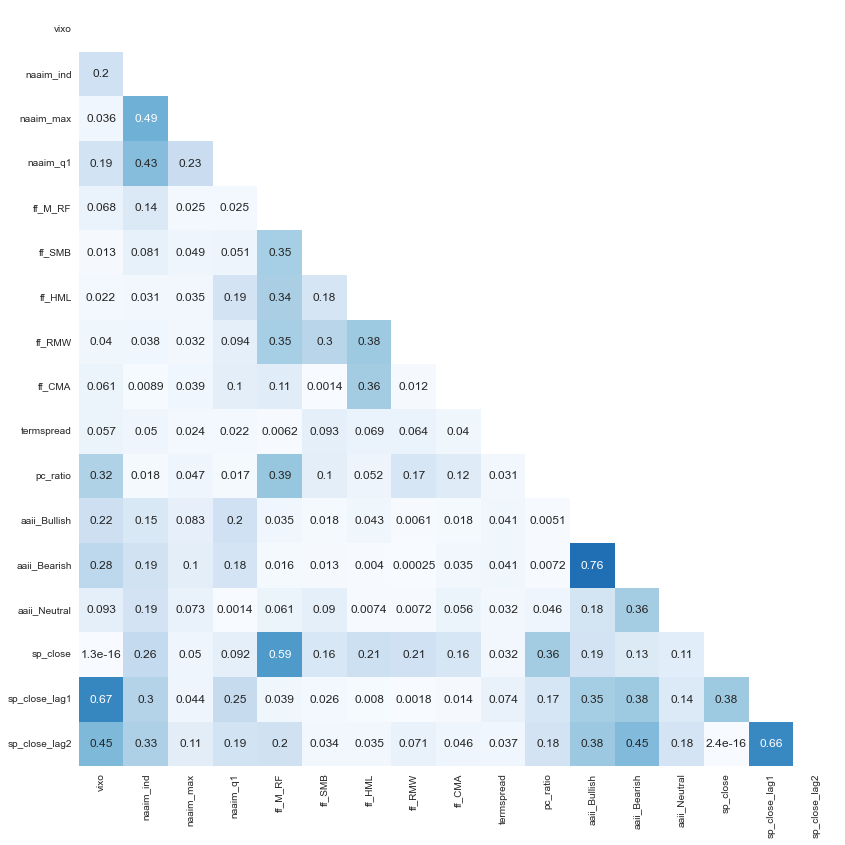

In [101]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             # size_factor=1,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["model_features"]["predicted"])

# Regression

In [102]:
df_train = df_ws.copy()

In [103]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.2,
                                            add_const=False)

In [104]:
model = SKLearnWrap(sm.OLS, fit_intercept=True)
model_ = model.fit(X_train, y_train)

In [105]:
data_dict["model_metrics"].update(featuer_sig=model.results_.pvalues)
model.results_.pvalues < .05

vixo              True
naaim_ind        False
naaim_max        False
naaim_q1         False
ff_M_RF          False
ff_SMB            True
ff_HML           False
ff_RMW           False
ff_CMA           False
termspread       False
pc_ratio          True
aaii_Bullish     False
aaii_Bearish     False
aaii_Neutral     False
sp_close          True
sp_close_lag1    False
sp_close_lag2    False
intercept        False
dtype: bool

In [106]:
model.results_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     63.73
Date:                Mon, 14 Mar 2022   Prob (F-statistic):          1.15e-114
Time:                        17:02:06   Log-Likelihood:                 1508.3
No. Observations:                 533   AIC:                            -2981.
Df Residuals:                     515   BIC:                            -2904.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
vixo             -0.0618      0.008     -7.465      0.000      -0.078      -0.046
naaim_ind        -0.0007      0.002     -0.285      0.776      -0.005       0.004
naaim_max      2.076e-05      0.000      0.056      0.955      -0.001       0.001
naaim_q1         -0.0024      0.002     -0.995      0.320      -0.007       0.002
ff_M_RF           0.0015      0.001      1.842      0.066      -0.000       0.003
ff_SMB            0.0028      0.001      2.229      0.026       0.000       0.005
ff_HML           -0.0004      0.001     -0.379      0.705      -0.003       0.002
ff_RMW           -0.0003      0.002     -0.170      0.865      -0.004       0.004
ff_CMA            0.0030      0.002      1.220      0.223      -0.002       0.008
termspread        0.0052      0.005      0.980      0.328      -0.005       0.016
pc_ratio         -0.0086      0.004     -2.037      0.042      -0.017      -0.000
aaii_Bullish     -0.0046      0.008     -0.567      0.571      -0.021       0.011
aaii_Bearish      0.0034      0.008      0.432      0.666      -0.012       0.019
aaii_Neutral      0.0047      0.006      0.802      0.423      -0.007       0.016
sp_close          0.6892      0.061     11.299      0.000       0.569       0.809
sp_close_lag1     0.1262      0.065      1.934      0.054      -0.002       0.254
sp_close_lag2     0.0056      0.048      0.117      0.907      -0.089       0.100
intercept         0.0009      0.001      1.447      0.148      -0.000       0.002
==============================================================================
Omnibus:                       32.016   Durbin-Watson:                   2.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.244
Skew:                          -0.094   Prob(JB):                     3.13e-24
Kurtosis:                       5.200   Cond. No.                         279.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Out of sample eval

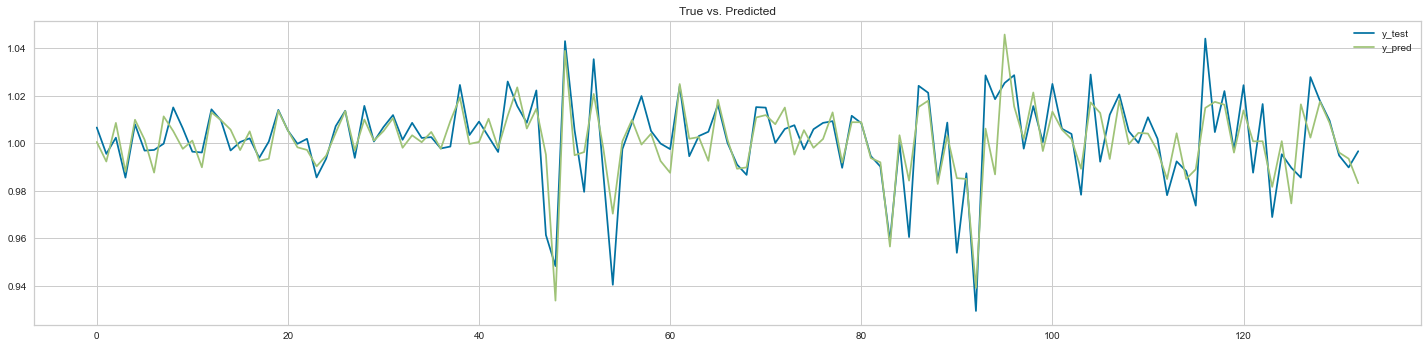

Validation Scores
mean squared error: 0.0001147312
mean absolute error: 0.0076314727
R2: 0.6475414298


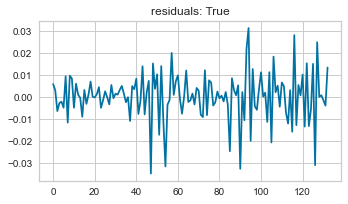

Stationarity Test Results
P-Values: 5.0093812568668546e-11
Test-stats: -7.472586207415689
Time series is stationary: True


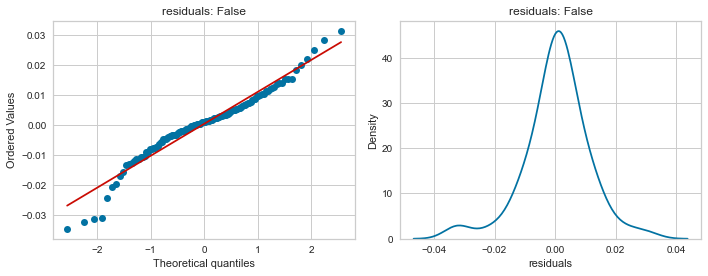

Normality Test Results
P-Values: 0.0008519013280494087
Test-stats: 14.13607969998057
Series is normally distributed: False
HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


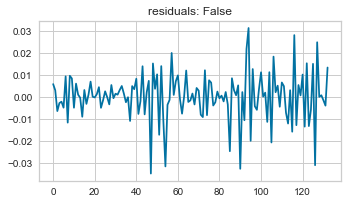

Test for Heteroskedasticity
Test p-value: 0.4592153982780815
Heteroskedasticity is present: False


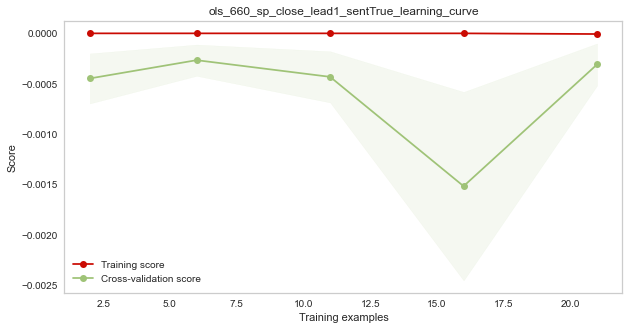

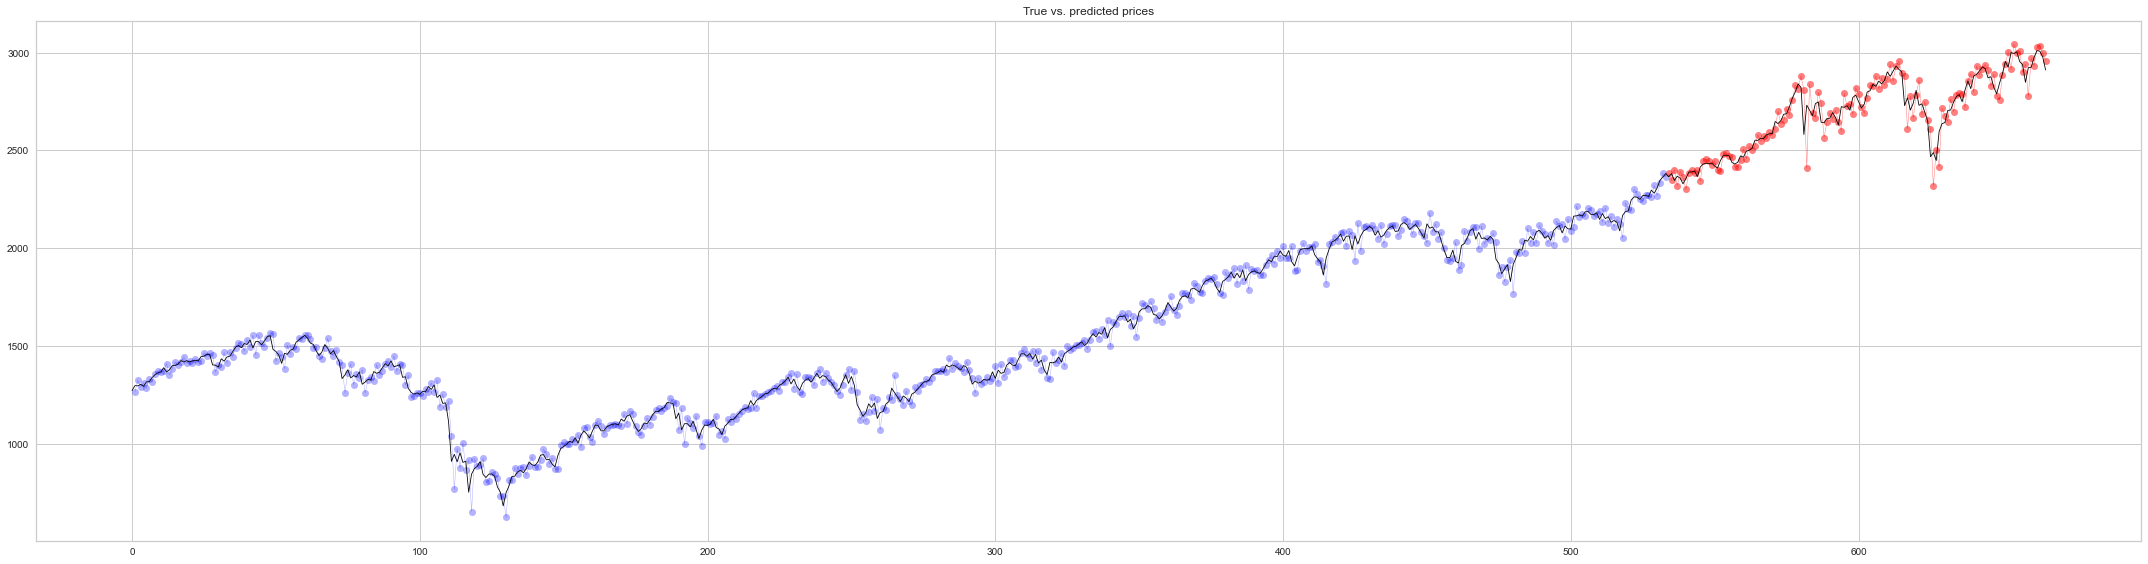

Validation Scores Test Data
mean squared error: 4381.7503998334
mean absolute error: 46.6665000147
mean absolute error in %: 0.026586343865261534
r2: 0.8752982408


In [107]:
mval = ModelValidation(
            X_train=X_train,
            y_train=y_train,
            X_validate=X_test,
            y_validate=y_test,
            model=model,
            print_results=True)

fig_true_vs_fit = mval.get_model_performance()
stat, norm, hetero = mval.analyse_resids()

fig_lcurve = mval.sm_learning_curve(f"{data_dict['model_metrics']['model_name']}_learning_curve", n_splits=8)
fig_prices = mval.plot_results_on_price_scale(df_w,
                                              df_ws,
                                              sp_true_vals=data_dict["data"]["sp_true_vals"])

# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)

# model performance
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid_inv)

# Save model

In [47]:
save_model(model, df_train, data_dict, fig_true_vs_fit, fig_lcurve, fig_prices, OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-14_ols_1560_sp_close_lead1_sentTrue"? (y/n)


 y
